In [1]:
import math
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.stats import multivariate_normal

import prince

import matplotlib.pyplot as plt
from matplotlib import cm 
from matplotlib.colors import from_levels_and_colors
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore') 

%matplotlib inline

In [2]:
sp500_px = pd.read_csv('./data/sp500_data.csv.gz', index_col=0)
sp500_sym = pd.read_csv('./data/sp500_sectors.csv')
loan_data  = pd.read_csv('./data/loan_data.csv.gz')
housetasks = pd.read_csv('./data/housetasks.csv', index_col=0)

In [3]:
oil_px = sp500_px[['XOM', 'CVX']]
print(oil_px.head())

                 XOM       CVX
1993-01-29 -0.016991  0.072921
1993-02-01  0.016991  0.102089
1993-02-02  0.084954  0.029168
1993-02-03  0.067964  0.058337
1993-02-04  0.034378  0.044272


In [4]:
pcs = PCA(n_components=2)
pcs.fit(oil_px)
loadings = pd.DataFrame(pcs.components_, columns=oil_px.columns)
print(loadings)

        XOM       CVX
0 -0.664711 -0.747101
1  0.747101 -0.664711


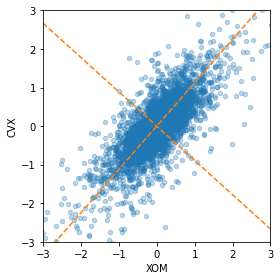

In [5]:
def abline(slope, intercept, ax):
    """Calculate coordinates of a line based on slope and intercept"""
    x_vals = np.array(ax.get_xlim())
    return (x_vals, intercept + slope * x_vals)

ax = oil_px.plot.scatter(x='XOM', y='CVX', alpha=0.3, figsize=(4, 4))
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.plot(*abline(loadings.loc[0, 'CVX'] / loadings.loc[0, 'XOM'], 0, ax),
        '--', color='C1')
ax.plot(*abline(loadings.loc[1, 'CVX'] / loadings.loc[1, 'XOM'], 0, ax),
        '--', color='C1')

plt.tight_layout()
plt.show()

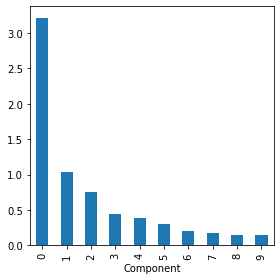

In [6]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP',
        'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]

sp_pca = PCA()
sp_pca.fit(top_sp)

explained_variance = pd.DataFrame(sp_pca.explained_variance_)
ax = explained_variance.head(10).plot.bar(legend=False, figsize=(4, 4))
ax.set_xlabel('Component')

plt.tight_layout()
plt.show()

In [7]:
loadings = pd.DataFrame(sp_pca.components_[0:5, :], 
                        columns=top_sp.columns)
print(loadings)

       AAPL       AXP       COP      COST      CSCO       CVX        HD  \
0 -0.300825 -0.246332 -0.261529 -0.273634 -0.064059 -0.444490 -0.207983   
1 -0.505116 -0.139426  0.174212 -0.416307 -0.031939  0.289373 -0.278002   
2 -0.786730  0.135458 -0.002367  0.465862 -0.007524  0.082374  0.166320   
3 -0.120586  0.061814 -0.206026  0.092596  0.003904 -0.577665  0.162814   
4  0.111576 -0.596666 -0.005813  0.555529 -0.039860  0.109016 -0.185488   

       INTC       JPM      MSFT       SLB       TGT       USB       WFC  \
0 -0.076956 -0.196397 -0.105012 -0.481786 -0.148833 -0.116421 -0.145684   
1 -0.033898 -0.040723 -0.053954  0.472494 -0.228123 -0.054796 -0.047427   
2 -0.003518  0.062261  0.016248 -0.194822  0.160833  0.048976  0.041932   
3 -0.001605  0.057687 -0.012558  0.680914  0.109895  0.016752  0.018614   
4 -0.072047 -0.385160 -0.077135  0.181332 -0.055557 -0.155440 -0.216425   

        WMT       XOM  
0 -0.122304 -0.317952  
1 -0.222889  0.154192  
2  0.175806  0.090167  
3 

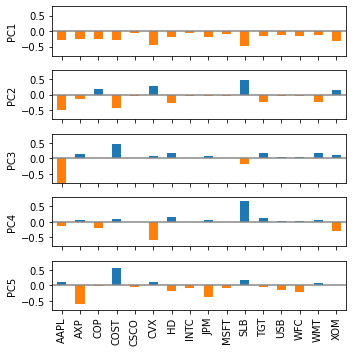

In [8]:
maxPC = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()

f, axes = plt.subplots(5, 1, figsize=(5, 5), sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings.loc[i, :]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

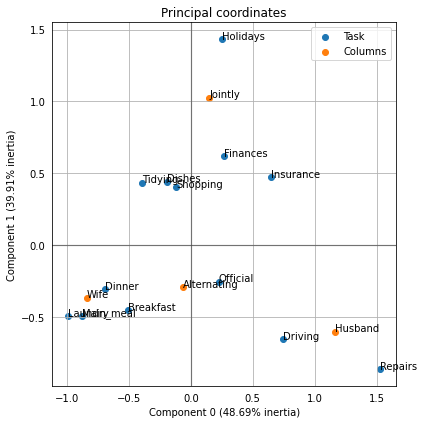

In [9]:
ca = prince.CA(n_components=2)
ca = ca.fit(housetasks)

ca.plot_coordinates(housetasks, figsize=(6, 6))
plt.tight_layout()
plt.show()

In [10]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
kmeans = KMeans(n_clusters=4).fit(df)
df['cluster'] = kmeans.labels_
print(df.head())

                 XOM       CVX  cluster
2011-01-03  0.736805  0.240681        1
2011-01-04  0.168668 -0.584516        3
2011-01-05  0.026631  0.446985        1
2011-01-06  0.248558 -0.919751        3
2011-01-07  0.337329  0.180511        1


In [11]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=['XOM', 'CVX'])
print(centers)

        XOM       CVX
0 -1.143980 -1.750297
1  0.231540  0.316965
2  0.927032  1.346412
3 -0.328742 -0.573470


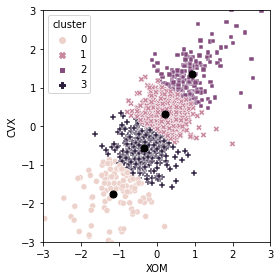

In [12]:
fig, ax = plt.subplots(figsize=(4, 4))
ax = sns.scatterplot(x='XOM', y='CVX', hue='cluster', style='cluster', 
                     ax=ax, data=df)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
centers.plot.scatter(x='XOM', y='CVX', ax=ax, s=50, color='black')

plt.tight_layout()
plt.show()

In [13]:
syms = sorted(['AAPL', 'MSFT', 'CSCO', 'INTC', 'CVX', 'XOM', 'SLB', 'COP', 
               'JPM', 'WFC', 'USB', 'AXP', 'WMT', 'TGT', 'HD', 'COST'])
top_sp = sp500_px.loc[sp500_px.index >= '2011-01-01', syms]
kmeans = KMeans(n_clusters=5).fit(top_sp)

In [14]:
from collections import Counter
print(Counter(kmeans.labels_))

Counter({3: 301, 2: 294, 4: 266, 1: 158, 0: 112})


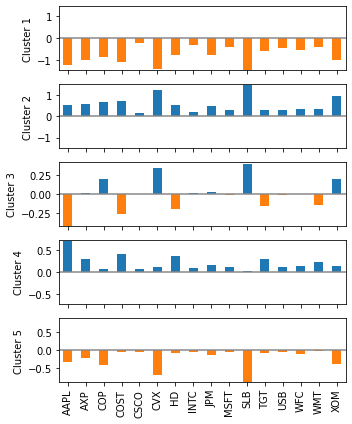

In [15]:
centers = pd.DataFrame(kmeans.cluster_centers_, columns=syms)

f, axes = plt.subplots(5, 1, figsize=(5, 6), sharex=True)
for i, ax in enumerate(axes):
    center = centers.loc[i, :]
    maxPC = 1.01 * np.max(np.max(np.abs(center)))
    colors = ['C0' if l > 0 else 'C1' for l in center]
    ax.axhline(color='#888888')
    center.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'Cluster {i + 1}')
    ax.set_ylim(-maxPC, maxPC)

plt.tight_layout()
plt.show()

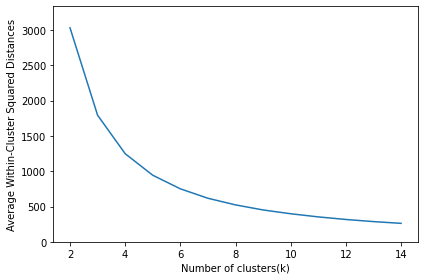

In [16]:
inertia = []
for n_clusters in range(2, 15):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(top_sp)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(2, 15), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)

plt.tight_layout()
plt.show()

In [ ]:
syms1 = ['AAPL', 'AMZN', 'AXP', 'COP', 'COST', 'CSCO', 'CVX', 'GOOGL', 'HD', 
         'INTC', 'JPM', 'MSFT', 'SLB', 'TGT', 'USB', 'WFC', 'WMT', 'XOM']
df = sp500_px.loc[sp500_px.index >= '2011-01-01', syms1].transpose()

Z = linkage(df, method='complete')
print(Z.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
dendrogram(Z, labels=list(df.index), color_threshold=0)
plt.xticks(rotation=90)
ax.set_ylabel('distance')

plt.tight_layout()
plt.show()

In [ ]:
memb = fcluster(Z, 4, criterion='maxclust')
memb = pd.Series(memb, index=df.index)
for key, item in memb.groupby(memb):
    print(f"{key} : {', '.join(item.index)}")

In [ ]:
df = sp500_px.loc[sp500_px.index >= '2011-01-01', ['XOM', 'CVX']]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(5, 5))
for i, method in enumerate(['single', 'average', 'complete', 'ward']):
    ax = axes[i // 2, i % 2]
    Z = linkage(df, method=method)
    colors = [f'C{c+1}' for c in fcluster(Z, 4, criterion='maxclust')]
    ax = sns.scatterplot(x='XOM', y='CVX', hue=colors, style=colors,
                         size=0.5, ax=ax, data=df, legend=False)

    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_title(method)

plt.tight_layout()
plt.show()